In [1]:
import os
import re
import zipfile
import shutil
import pathlib

In [2]:
from fastai import * 
from fastai.vision import *

In [3]:
# set batchsize
bs = 64

### Extracting Data

In [4]:
path = pathlib.Path().absolute()

In [ ]:
import zipfile

zip_path = Path('/home/jupyter/victor_projects/chest_xrays/data/xray_data.zip')
extract_path = Path('/home/jupyter/victor_projects/chest_xrays/data')

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
shutil.move('/home/jupyter/victor_projects/chest_xrays/data/xray_data',\
            '/home/jupyter/victor_projects/chest_xrays')

### Creating Dataset

In [5]:
path = Path('/home/jupyter/victor_projects/chest_xrays/data')

np.random.seed(7)

In [6]:
data = ImageDataBunch.from_folder(path,
                                  test='test',
                                  valid_pct=0.2,
                                  no_check=True,
                                  ds_tfms=get_transforms(),
                                  size=224,
                                  bs=bs).normalize(imagenet_stats)

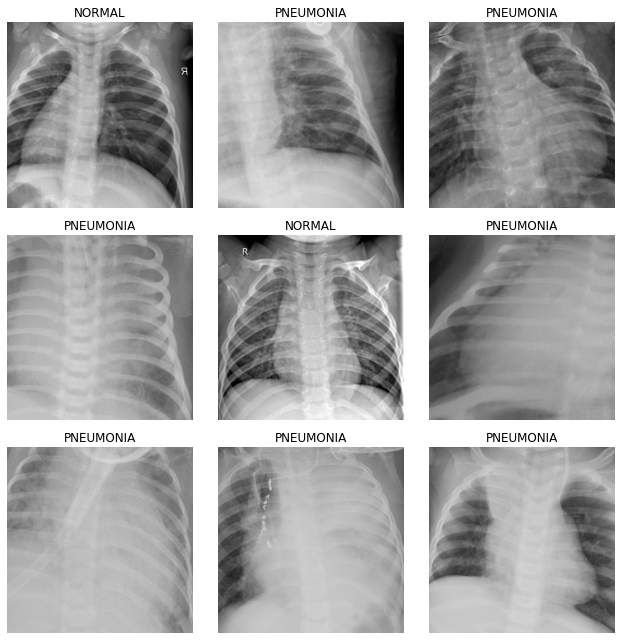

In [7]:
data.show_batch(rows=3, figsize=(9,9))

In [8]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds), len(data.test_ds)

(['NORMAL', 'PNEUMONIA'], 2, 4186, 1046, 624)

### Creating & Training Model
There are two kinds of pneumonia: bacterial and viral. For now both of these pneumonia are aggregated into the "pneumonia" label. I will be utilizing the ResNet 50 architecture CNN.

In [9]:
learner = cnn_learner(data,
                      models.resnet50,
                      metrics=[accuracy, error_rate],
                      model_dir='/home/jupyter/victor_projects/chest_xrays/models')

In [10]:
learner.save('empty')

In [11]:
learner.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.444423,0.546270,0.907266,0.092734,01:17
1,0.259345,0.304000,0.928298,0.071702,01:01
2,0.178671,0.186940,0.935946,0.064054,01:00
3,0.153706,0.166886,0.943595,0.056405,01:00


In [12]:
learner.save('stage_1')

In [13]:
# before unfreezing test
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


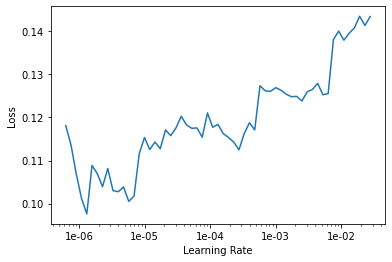

In [14]:
learner.recorder.plot()

In [ ]:
# testing with pre-frozen learning rate
learner.fit_one_cycle(10, max_lr=slice(2e-06,9e-06))

In [ ]:
learner.save('stage_2_frozen')

In [ ]:
learner.load('stage_1')

In [ ]:
learner.unfreeze()

In [ ]:
learner.lr_find()

In [ ]:
learner.recorder.plot()

In [ ]:
learner.fit_one_cycle(10, max_lr=slice(None, 0.003, None))

In [ ]:
learner.save('stage_2')

## Splitting "pneumonia" class into "bacterial" and "viral"

Since data is not organized into "bacterial" and "viral" directories, we will use a regular expression to extract them.

Plan: move all data into one folder and create my own train/valid/test splits then use RegEx to create labels

### Deleting and organizing directories

In [ ]:
shutil.rmtree(Path('/home/jupyter/victor_projects/chest_xrays/data2'))

In [ ]:
copy = Path('/home/jupyter/victor_projects/chest_xrays/data')
dest = Path('/home/jupyter/victor_projects/chest_xrays/data2')

shutil.copytree(copy, dest)

In [ ]:
os.listdir(orig)

In [ ]:
os.listdir(orig)

In [ ]:
# Move all folders out of NORMAL, PNEUMONIA and into data2

orig = '/home/jupyter/victor_projects/chest_xrays/data2/PNEUMONIA3'
dest = '/home/jupyter/victor_projects/chest_xrays/data2'

for i in os.listdir(orig):
    shutil.copy(os.path.join(orig, i), dest)
    
shutil.rmtree(orig)

### Regular Expression Extraction
Looking through the data, I notice that the "pneumonia" lung pictures are labelled "personXXX_bacteria_XXX.jpeg" or "personXXX_virus_XXX.jpeg" denoting the label. Whereas the "normal" lung picture are either labelled "IM-XXX-XXX.jpeg" or "NORMAL2-IM-XXXX-XXXX.jpeg" where "X" is some number. For example "IM-0085-0001.jpeg" or "NORMAL2-IM-0692-0001.jpeg". There are also "normal" lung pictures with more numbers after the "IM" or "NORMAL2". Therefore I will handle this with an "else" statement after my regular expression captures "virus" or "bacteria".

In [ ]:
path = pathlib.Path().absolute()

In [ ]:
path.ls()

In [ ]:
path_img = path/'data2'

In [ ]:
fn_paths = get_image_files(path_img)
fn_paths[:11]

In [ ]:
# Create custom regular expression function since three different formats of path names

def get_labels(path):
    pat = re.search('/person[\d]+_(virus|bacteria)_[\d]+\.jpeg$', str(path))
    if (pat):
        return pat[1]
    else:
        return 'normal'

In [ ]:
np.random.seed(2)
data = ImageDataBunch.from_name_func(path_img, fn_paths, 
                                     label_func=get_labels,
                                     ds_tfms=get_transforms(),
                                     size=224,bs=bs).normalize(imagenet_stats)

In [ ]:
data.show_batch(rows=3,figsize=(9,9))

In [ ]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

## Training Model
I will utilize transfer learning by using my already trained 